This notebook is an implementation of a continuous Hopfield network for the purpose of remembering images.

It uses the continuous updating rule of $\tau_i \frac{dV_i}{dt} = -V_i + g_\beta (u_i) = -V_i + g_\beta (\sum_j W_{ij}V_j)$

Cheat sheet:

- $V$ is a vector of all the neurons. In our case, each neuron represents a pixel where the value is between $[-1, 1]$
- $g_\beta$ is a continuous non-linear function. In our case, we use tanh, which outputs values between $[-1, 1]$
- $W$ is the symmetric weight matrix representing the connections between neurons. $W_{ii} = 0$ and $W_{ij} = W_{ji}$. It is initialized by setting $W_{ij} = V_iV_j$ where $V$ is initialized to the state you want the network to "memorize". If you want the network to remember multiple of these states, simply set $W$ to the sum of all the $W$ matrices, one computed for each state.


In [1]:
import numpy as np

# Grayscale

In [2]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

num_images = 3
data_file_path = "data_batch_1"
data = unpickle(data_file_path)[b'data']
images = []

color_enabled = True
num_neurons = 3072

X = np.empty((num_neurons, 0))

for i in range(num_images):
    grayscale_img = np.mean(data[i].reshape((3,1024)), axis=0)
    X = np.hstack((X, grayscale_img.reshape(-1, 1)))
    grayscale_img = grayscale_img.reshape((32,32))
    plt.imshow(grayscale_img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()
    grayscale_img = (grayscale_img - 127.5) / 127.5 # normalizing between [-1, 1]
    images.append(grayscale_img)

color_enabled = False
num_neurons = 1024
W = np.zeros((num_neurons, num_neurons))

# computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)

for image in images:
    image_normalized = image / np.linalg.norm(image)
    W += np.outer(image_normalized, image_normalized) 

W = W / num_images

np.fill_diagonal(W, 0)

FileNotFoundError: [Errno 2] No such file or directory: 'data_batch_1'

# Color

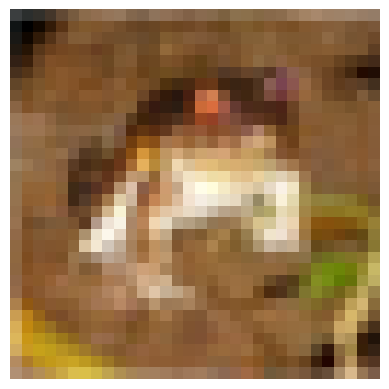

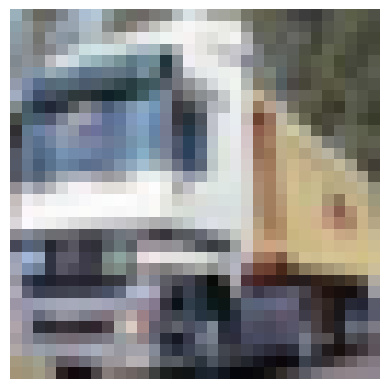

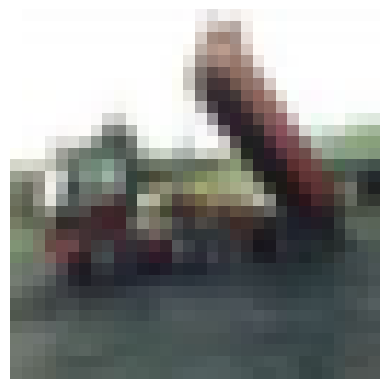

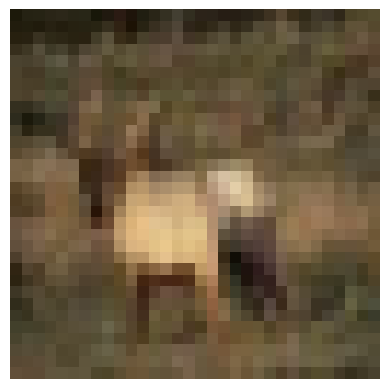

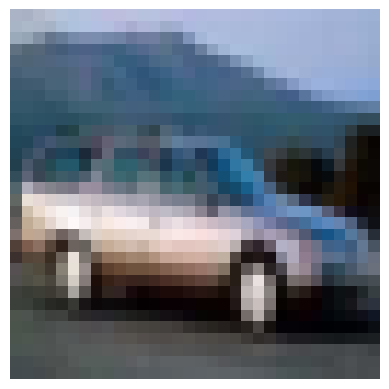

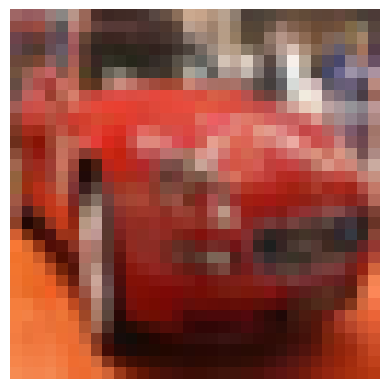

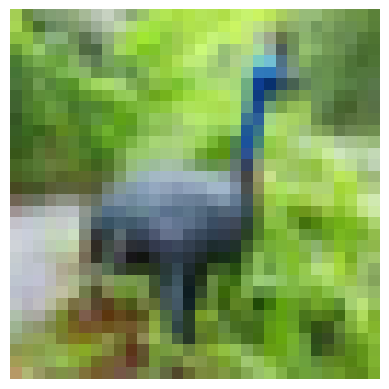

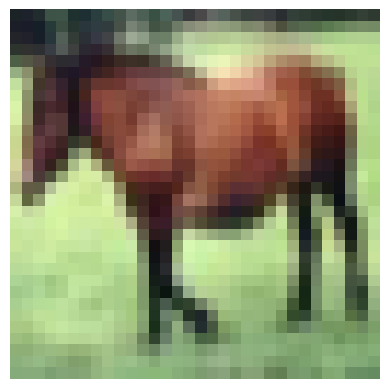

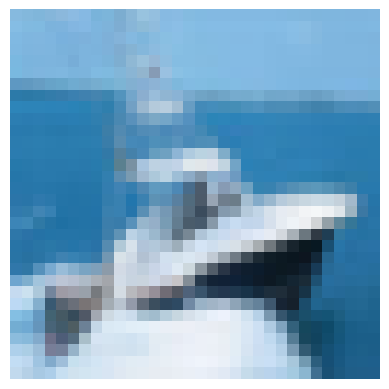

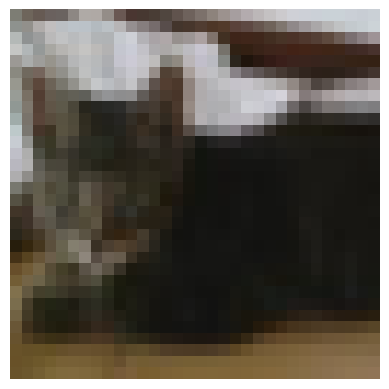

In [94]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

num_images = 10
data_file_path = "data_batch_1"
data = unpickle(data_file_path)[b'data']
images = []

color_enabled = True
num_neurons = 3072

X = np.empty((num_neurons, 0))

for i in range(num_images):
    color_img = data[i].reshape((3,32,32)).transpose(1,2,0)    
    plt.imshow(color_img, interpolation='none')
    plt.axis('off')
    plt.show()
    X = np.hstack((X, color_img.flatten().reshape(-1, 1)))
    color_img = (color_img - 127.5) / 127.5 # normalizing between [-1, 1]
    images.append(color_img)


W = np.zeros((num_neurons, num_neurons))

# computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)

for image in images:
    image_normalized = image / np.linalg.norm(image)
    W += np.outer(image_normalized, image_normalized) 

W = W / num_images

np.fill_diagonal(W, 0)

In [66]:
from scipy.integrate import solve_ivp

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

# constants
def g(u, beta = 7):
    return np.tanh(u * beta)

def sigmoid(u, scaling_factor=2):
    return 1 / (1 + np.exp(-u / scaling_factor))

def energy(v):
    return -0.5 * g(v).T @ W @ g(v) + np.sum(np.log(np.cosh(v)))

tol = 1e-4 # integrate until converging to this tolerance
dt = 0.001

def hopfield_diff_eq(t, v):
    dvdt = (-v + W @ g(v))
    return dvdt

In [67]:
# If you want random noise, choose the top V. If you want to start it at a specific image, choose the bottom V.

V = np.random.uniform(-1.0, 1.0, size=(num_neurons))
# V = images[2].flatten()
# choice = np.random.choice(len(images))
# print(choice)
# V = images[choice].flatten()

time = 0 # for integration, this is the starting time at first
times = [time]
states = [V]

current_state = V
prev_state = V + 2 * tol # This makes the first iteration of the loop work

# while np.abs(current_state - prev_state).max() > tol:
#     prev_state = current_state
#     result = solve_ivp(hopfield_diff_eq, (time, time + dt), current_state, method='RK45', t_eval=[time+dt])
    
#     current_state = result.y[:, -1]
#     time += dt
#     times.append(time)
#     # states.append(current_state)
#     # current_state = prev_state + hopfield_diff_eq(0, prev_state) * dt
#     states.append(current_state)


result = solve_ivp(hopfield_diff_eq, (0, 100), current_state, method='RK45', t_eval=[100])
states.append(result.y[:, -1])

times = np.array(times)
states = np.array(states)



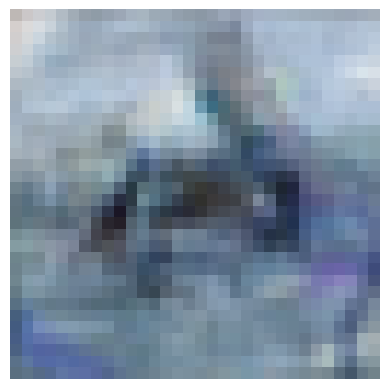

In [71]:
if color_enabled:
    final_img = states[-1].reshape((32,32,3))
else:
    final_img = states[-1].reshape((32,32))

final_img = (final_img+1)/2

if color_enabled:
    plt.imshow(final_img, interpolation='none')
else:
    plt.imshow(final_img, cmap="gray", interpolation='none')
plt.axis('off')
plt.show()

In [6]:
def invert(image):
    return 1-image

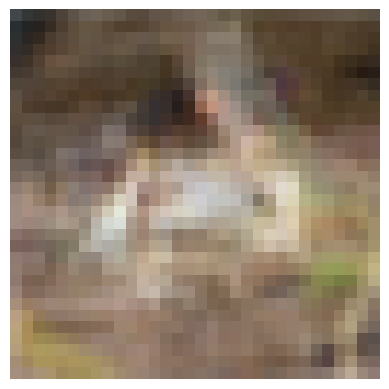

In [7]:
negative = invert(final_img)

if color_enabled:
    plt.imshow(negative, interpolation='none')
else:
    plt.imshow(negative, cmap="gray", interpolation='none')
plt.axis('off')
plt.show()

In [264]:
for image in images:
    print(cosine_similarity(final_img.flatten(), image.flatten()))

-0.494532144632739
0.018819212847012108
0.08106848660224104
-0.8310007822988416
-0.37610003165430167
-0.5892251502245595
-0.1879099234215986
-0.127535758369217
0.41921511804214767
-0.7118951554379563


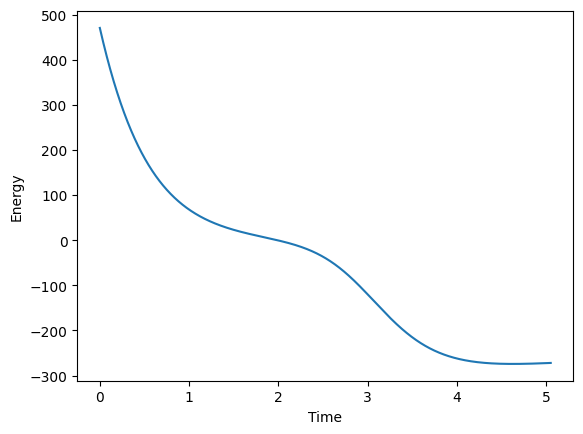

In [216]:
energies = [energy(state) for state in states]
plt.plot(times, energies)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.show()

# Hopfield Networks is all you need

In [73]:
def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def modern_hopfield_step(X,xi,beta=1):
    xinew = X@softmax(beta*X.T@xi)
    return xinew

def modern_hopfield_step_normalization(X, xi, beta=0.0001):
    # Normalize X columns and xi for similarity calculation
    X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
    xi_norm = xi / np.linalg.norm(xi)
    
    # Compute new state
    similarities = X_norm.T @ xi_norm  # Cosine similarities
    xinew = X @ softmax(beta * similarities)
    return xinew


In [227]:
# V = np.random.uniform(0.1, 255.0, size=(num_neurons))
V = X[:, 0]
choice = np.random.choice(len(images))
print(choice)
V = X[:, choice]

current_state = V + 0.01 * np.random.randn(*V.shape)
prev_state = V + 2 * tol

states = [current_state]

iter_count = 0

while np.abs(current_state - prev_state).max() > tol:
    iter_count += 1 
    prev_state = current_state
    current_state = modern_hopfield_step(X, prev_state)
    states.append(current_state)

print(iter_count)


if color_enabled:
    for img in states:
        print(np.min(img))
        final_img = img.reshape((32,32,3)) / 255.0
        plt.imshow(final_img, interpolation='none')
        plt.axis('off')
        plt.show()
else:
    for img in states:
        final_img = img.reshape((32,32)) / 255.0
        plt.imshow(final_img, cmap="gray", interpolation='none')
        plt.axis('off')
        plt.show()

NameError: name 'X' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.796058103454013e-05..1.0000338417177868].


-0.014779948163807732


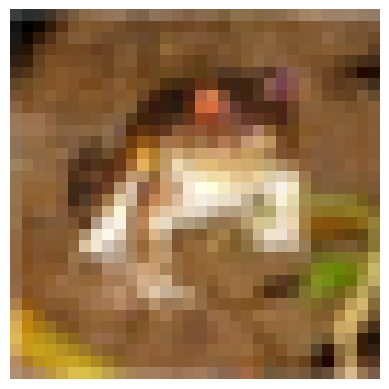

35.66446885406572


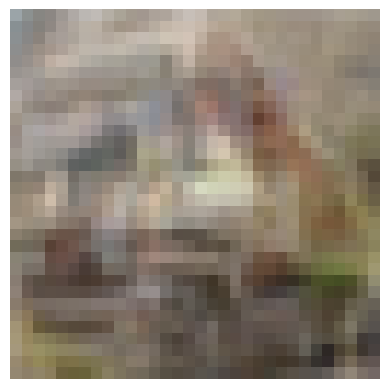

35.669526459927226


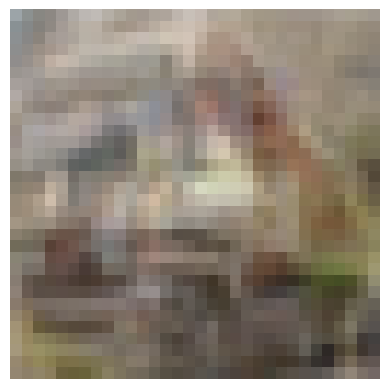

35.6695282329523


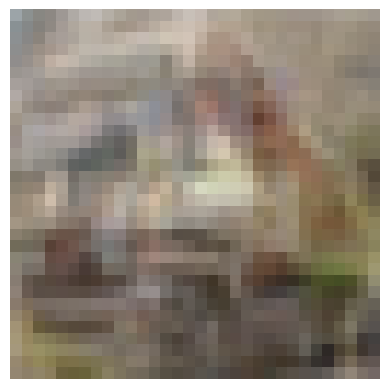

In [41]:
if color_enabled:
    for img in states:
        print(np.min(img))
        final_img = img.reshape((32,32,3)) / 255.0
        plt.imshow(final_img, interpolation='none')
        plt.axis('off')
        plt.show()
else:
    for img in states:
        final_img = img.reshape((32,32)) / 255.0
        plt.imshow(final_img, cmap="gray", interpolation='none')
        plt.axis('off')
        plt.show()

In [407]:
np.min(X)

0.0

In [306]:
current_state

array([255., 255., 255., ...,  80.,  86.,  84.])

In [345]:
V = X[:, 0]
V.shape

(3072,)

In [436]:
for i in range(X.shape[1]):
    print(np.linalg.norm(X[:,i]))

6416.603462892186
7964.367457620222
8711.389843188055
4884.421255379188
6644.910006915067
6039.182808956854
7257.420133904334
7504.499450329782
9085.38689324786
5034.667417019718


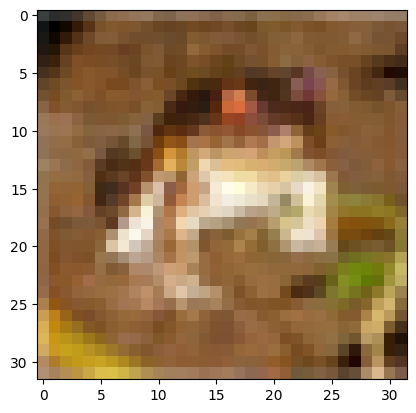

In [438]:
plt.imshow(X[:, 0].reshape((32,32,3)) / 255.0, interpolation='none')

# Discrete hopfield networks

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def show_image(img):
    final_img = img.reshape((32,32))
    plt.figure(figsize=(2,2))
    plt.imshow(final_img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()

# returns flattened images
def generate_uncorrelated_images(num_images, size: int, correlation_threshold):
    images = []

    while len(images) < num_images:
        image = np.random.choice([-1, 1], size=size)
        is_uncorrelated = True
        for existing_image in images:
            correlation = abs(float(get_hamming_distance(existing_image, image)) / float(size))
            if correlation > correlation_threshold:
                is_uncorrelated = False
                break

        if is_uncorrelated:
            images.append(image)
            print(f"{len(images)} uncorrelated images")

    return np.array(images)

def discrete_update(num_neurons, W, states):
    i = np.random.randint(0, num_neurons)
    new_state = states[-1].copy()
    new_state[i] = np.sign(W[i,:]@new_state)
    return new_state

def discrete_energy(W, state):
    return -0.5 * state @ W @ state

def get_hamming_distance(img1, img2):
    if len(img1) != len(img2):
        print(f"Images must be same size, but have sizes {img1.shape} and {img2.shape}")
        exit(1)
    return len(img1) - np.count_nonzero(img1 == img2)

def hamming_distance_matrix(flattened_images):
    num_images = len(flattened_images)
    distances = np.empty((num_images, num_images,))
    for i in range(num_images):
        for j in range(num_images):
            distances[i,j] = get_hamming_distance(flattened_images[i], flattened_images[j])
            distances[j,i] = get_hamming_distance(flattened_images[i], flattened_images[j])
    print(distances)

# Outputs an array in the format [closest_input_image_index, hamming_distance_from_closest_input_image]
def is_valid_memory(images, output_image, print_output=True):
    closest_ham = len(output_image)
    closest_index = -1
    for i in range(len(images)):
        ham = get_hamming_distance(images[i], output_image)
        inv_ham = get_hamming_distance(images[i], output_image * -1)
        if ham == 0 or inv_ham == 0:    # Checking for inverted 
            if print_output:
                print(f"Match for image {i}")
            return [i, 0]
        
        if ham < closest_ham:
            closest_ham = ham
            closest_index = i
        if inv_ham < closest_ham:
            closest_ham = inv_ham
            closest_index = i
    if print_output:
        print(f"Mutant, closest was image {closest_index} with hamming distance of {closest_ham}")
    return [closest_index, closest_ham]


def discrete_hopfield_trials(W, images, num_iter, num_trials):
    tol = 0.000001
    result = np.empty((num_trials, 2,))
    
    for trial in range(num_trials):
        V = np.random.choice([-1,1],size=len(images[0]))
        prev_state = V + 2 * tol # This makes the first iteration of the loop work
        states = [prev_state, V]

        for i in range(num_iter):
            states.append(discrete_update(num_neurons, W, states))
        temp = is_valid_memory(images, states[-1], print_output=False)
        result[trial][0] = temp[0]
        result[trial][1] = temp[1]
    return result.astype(int)


In [64]:
# square = np.full(pattern_size, -1.0)
# square[10:22, 10:22] = 1.0
# images.append(square)

# diagonal = np.full(pattern_size, -1.0)
# for i in range(2, 32, 8):
#     diagonal[i:i+4, i:i+4] = 1.0
# images.append(diagonal)

# square_plus = np.full(pattern_size, -1.0)
# square_plus[10:22, 10:22] = 1.0
# square_plus[0:6, 13:19] = 1.0
# square_plus[26:32, 13:19] = 1.0
# square_plus[13:19, 26:32] = 1.0
# square_plus[13:19, 0:6] = 1.0
# images.append(square_plus)

# big_x = np.full(pattern_size, 1.0)
# for i in range(2, 32, 4):
#     big_x[i:i+4, i:i+4] = -1.0
#     big_x[i:i+4, (28-i):(32-i)] = -1.0
# images.append(big_x)

# stripes = np.full(pattern_size, -1.0)
# for i in range(2, 32, 4):
#     stripes[i:i+2, :] = 1.0
# images.append(stripes)

# concentric = np.full(pattern_size, 1.0)
# start = 0
# stop = 31
# width = 2
# while start <= 16:
#     concentric[start:stop, start:start+width] = -1.0
#     concentric[start:stop, stop-width:stop] = -1.0
#     concentric[start:start+width, start:stop] = -1.0
#     concentric[stop-width:stop, start:stop] = -1.0
#     start += width * 2
#     stop -= width * 2 
# images.append(concentric)

1 uncorrelated images
2 uncorrelated images
3 uncorrelated images
4 uncorrelated images
5 uncorrelated images
6 uncorrelated images
7 uncorrelated images
8 uncorrelated images
9 uncorrelated images
10 uncorrelated images
11 uncorrelated images
12 uncorrelated images
13 uncorrelated images
14 uncorrelated images
15 uncorrelated images
16 uncorrelated images
17 uncorrelated images
18 uncorrelated images
19 uncorrelated images
20 uncorrelated images
21 uncorrelated images
22 uncorrelated images
23 uncorrelated images
24 uncorrelated images
25 uncorrelated images
26 uncorrelated images
27 uncorrelated images
28 uncorrelated images
29 uncorrelated images
30 uncorrelated images
[[  0. 499. 506. 495. 506. 505. 501. 483. 484. 476. 503. 496. 486. 488.
  489. 508. 489. 508. 500. 497. 492. 509. 509. 502. 512. 497. 493. 503.
  475. 501.]
 [499.   0. 501. 482. 505. 486. 502. 494. 505. 495. 500. 497. 503. 493.
  502. 497. 482. 487. 509. 468. 503. 496. 462. 487. 489. 494. 508. 498.
  506. 510.]
 [506

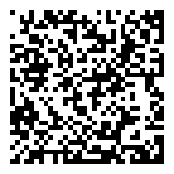

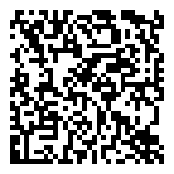

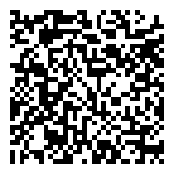

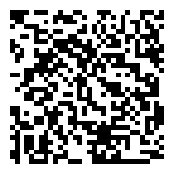

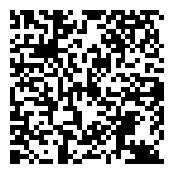

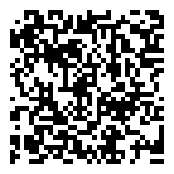

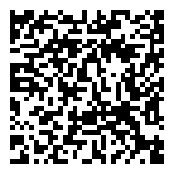

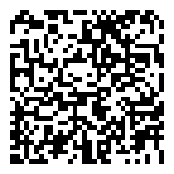

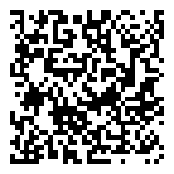

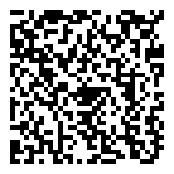

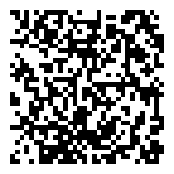

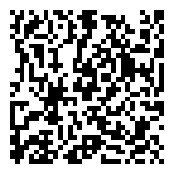

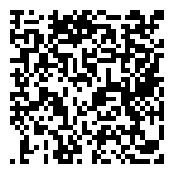

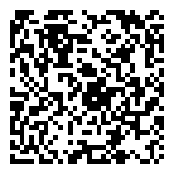

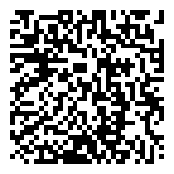

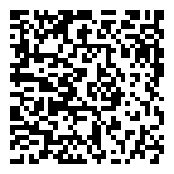

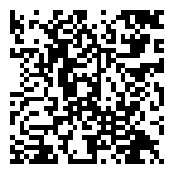

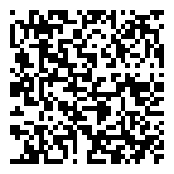

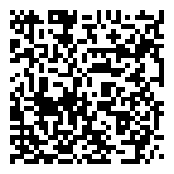

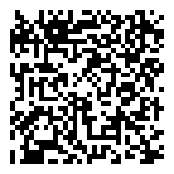

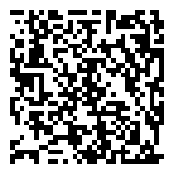

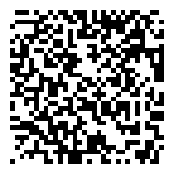

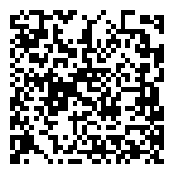

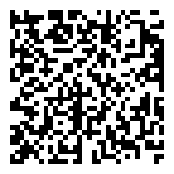

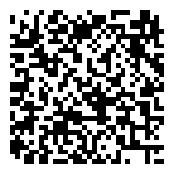

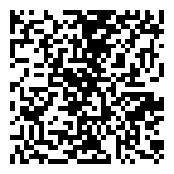

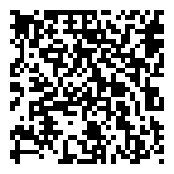

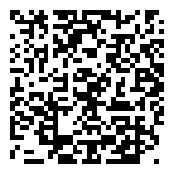

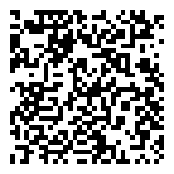

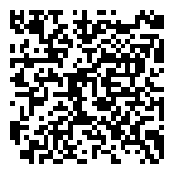

In [4]:
#Create 5 random patterns
# np.random.seed(13)
num_images = 30
image_length = 32 * 32
image_shape = (32, 32,)
images = generate_uncorrelated_images(num_images, image_length, 0.5)

hamming_distance_matrix(images)

for image in images:
    show_image(image)
color_enabled = False
num_neurons = 1024

# flattened_images = np.reshape(images, (num_images, num_neurons))
# W = images.T @ images
# # W = np.zeros((num_neurons, num_neurons))

# # # computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)

# # for image in images:
# #     image_normalized = image / np.linalg.norm(image)
# #     W += np.outer(image_normalized, image_normalized) 


In [246]:
# images = np.array(images)
# W = images.T @ images

# W = W / num_images

# np.fill_diagonal(W, 0.0)

# # If you want random noise, choose the top V. If you want to start it at a specific image, choose the bottom V.
# V = np.random.choice([-1,1],size=image_length)

# # V = np.full(pattern_size, 0.0).flatten()

# # V = images[2].flatten()
# # choice = np.random.choice(len(images))
# # print(choice)
# # V = images[choice].flatten()

# tol = 0.000001
# prev_state = V + 2 * tol # This makes the first iteration of the loop work
# states = [prev_state, V]

# print(V.shape)
# for i in range(10000):
#     states.append(discrete_update(num_neurons, W, states))
#     # if i % 50 == 0:
#         # show_image(image)
    
# # show_image(V)
# is_mutant(images, states[-1])
# show_image(states[-1])

# energies = [discrete_energy(W, state) for state in states]
# plt.plot(energies)
# plt.xlabel("Time")
# plt.ylabel("Energy")
# plt.show()

W = images.T @ images
W = W / num_images
np.fill_diagonal(W, 0.0)
num_trials = 1000
data = discrete_hopfield_trials(W, images, 10000, num_trials)

Mutant, closest was image 19 with hamming distance of 377
Mutant, closest was image 9 with hamming distance of 377
Mutant, closest was image 9 with hamming distance of 377
Mutant, closest was image 14 with hamming distance of 381
Mutant, closest was image 9 with hamming distance of 374
Mutant, closest was image 9 with hamming distance of 355
Mutant, closest was image 23 with hamming distance of 342
Mutant, closest was image 19 with hamming distance of 376
Mutant, closest was image 19 with hamming distance of 380
Mutant, closest was image 19 with hamming distance of 371
Mutant, closest was image 23 with hamming distance of 378
Match for image 7
Mutant, closest was image 24 with hamming distance of 371
Mutant, closest was image 23 with hamming distance of 332
Mutant, closest was image 29 with hamming distance of 375
Mutant, closest was image 23 with hamming distance of 313
Mutant, closest was image 23 with hamming distance of 373
Mutant, closest was image 23 with hamming distance of 341


KeyboardInterrupt: 

In [ ]:
# setup
print("total images: ", len(images))
image_length = 32 * 32
image_shape = (32, 32,)
num_neurons = 1024
num_trials = 1000
# num_images_arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30])
num_images_arr = np.array([1, 2, 3, 5, 10, 15, 20, 25, 30])

# store output
num_correct_arr = []
mci_arr = []  # mci = Most Common Incorrect image index
mci_proportion_arr = [] # number of times hopfield incorrectly guessed mci / total # times it recalled wrong memory
histogram_data = {}

# loop
for num_images in num_images_arr:
    trial_images = images[0:num_images]
    W = trial_images.T @ trial_images
    W = W / num_images
    np.fill_diagonal(W, 0.0)
    data = discrete_hopfield_trials(W, trial_images, 10000, num_trials)

    num_correct = np.sum(data[:, 1] == 0)
    num_incorrect = num_trials-num_correct
    print("num_images: ", len(trial_images))
    print("num_correct: ", num_correct)
    print("num_incorrect: ", num_incorrect)
    print("Percent correct: ", float(num_correct)/float(num_trials))

    if num_incorrect == 0:
        num_correct_arr.append(num_correct)
        mci_arr.append(np.nan)
        mci_proportion_arr.append(np.nan)
    else:
        incorrect_data = data[data[:, 1] > 0, :]
        counts, bins = np.histogram(data[:,1], bins=[0] + list(range(1, int(image_length/2), 100)))
        histogram_data[num_images] = [counts, bins]
        # plt.figure()
        # plt.bar(bins[:-1], counts, width=20, align="center")
        # plt.title(f"Error frequency when num_images = {num_images}")
        # plt.ylabel("# out of 1000")
        # plt.xlabel("Number of incorrect bits")
        # plt.show()
        mci = np.argmax(counts)
        num_mci = np.sum(incorrect_data[:, 0] == mci)
        mci_proportion = num_mci/float(num_incorrect)
        # print("mci: ", mci)
        # print("num_mci: ", num_mci)
        # print("mci_proportion: ", mci_proportion)
        # print(incorrect_data)
        num_correct_arr.append(num_correct)
        mci_arr.append(mci)
        mci_proportion_arr.append(mci_proportion)

num_correct_arr = np.array(num_correct_arr)
mci_arr = np.array(mci_arr)  
mci_proportion_arr = np.array(mci_proportion_arr)

np.savez("discrete_hopfield_data", num_correct_arr=num_correct_arr, mci_arr=mci_arr, mci_proportion_arr=mci_proportion_arr, num_images_arr=num_images_arr)


total images:  30
num_images:  1
num_correct:  965
num_incorrect:  35
Percent correct:  0.965
num_images:  2
num_correct:  965
num_incorrect:  35
Percent correct:  0.965
num_images:  3
num_correct:  700
num_incorrect:  300
Percent correct:  0.7
num_images:  5
num_correct:  605
num_incorrect:  395
Percent correct:  0.605
num_images:  10
num_correct:  577
num_incorrect:  423
Percent correct:  0.577


[-35.0, -25.0, -15.0, -5.0, 5.0, 15.0, 25.0]
[-35.  66. 166. 266. 366. 466.]
[-25.  76. 176. 276. 376. 476.]
[-15.  86. 186. 286. 386. 486.]
[ -5.  96. 196. 296. 396. 496.]
[  5. 106. 206. 306. 406. 506.]
[ 15. 116. 216. 316. 416. 516.]
[ 25. 126. 226. 326. 426. 526.]


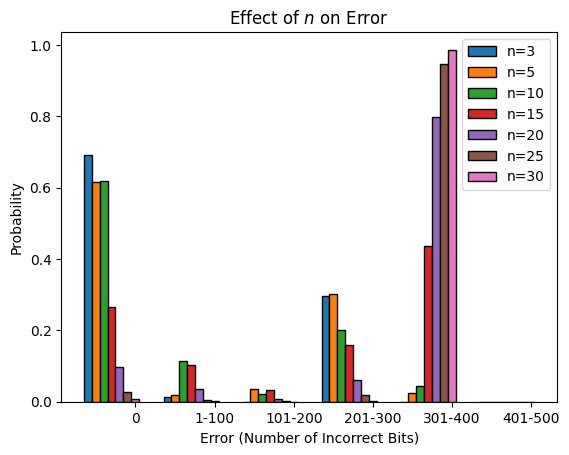

In [118]:
# bar_width = 10
# for n in histogram_data.keys():
#     counts = histogram_data[n][0]
#     bins = histogram_data[n][1][:-1]
#     plt.bar(bins, counts, width=bar_width, align="center", label=f"n={n}", edgecolor="k")
#     # plt.show()
# # plt.xticks([r + bar_width for r in range((counts))], 
# #         ['0', '50', '100', '150', '200', '250', '300', '350', '400', '450', '500'])
# plt.title(f"Error frequency when num_images = {num_images}")
# plt.ylabel("Probability")
# plt.xlabel("Number of incorrect bits")
# plt.legend()
# plt.show()

# bar_width = 10
# num_bars = len(histogram_data.keys())
# x_offsets = [(i - num_bars / 2) * bar_width for i in range(num_bars)]
# print(x_offsets)
# for i, (n, data) in enumerate(histogram_data.items()):
#     counts = data[0]
#     bins = data[1][:-1]
#     adjusted_bins = bins + x_offsets[i]
#     plt.bar(adjusted_bins, counts/float(num_trials), width=bar_width, align="center", label=f"n={n}", edgecolor="k")

# plt.title(f"Error frequency when num_images = {num_images}")
# plt.ylabel("Probability")
# plt.xlabel("Number of incorrect bits")
# # plt.gca().set_xticks(adjusted_bins, labels=["0", "1-100", "101-200", "201-300", "301-400", "401-500"])
# plt.legend()
# plt.show()

bar_width = 10
num_bars = len(histogram_data.keys())
x_offsets = [(i - num_bars / 2) * bar_width for i in range(num_bars)]
print(x_offsets)
for i, (n, data) in enumerate(histogram_data.items()):
    counts = data[0]
    bins = data[1][:-1]
    adjusted_bins = bins + x_offsets[i]
    adjusted_bins[1:] = adjusted_bins[1:] + 100
    plt.bar(adjusted_bins, counts/float(num_trials), width=bar_width, align="center", label=f"n={n}", edgecolor="k")
    print(adjusted_bins)

plt.title(f"Effect of $n$ on Error")
plt.ylabel("Probability")
plt.xlabel("Error (Number of Incorrect Bits)")

plt.gca().set_xticks(adjusted_bins, labels=["0", "1-100", "101-200", "201-300", "301-400", "401-500"])
plt.legend()
plt.show()

Text(0.5, 1.0, 'Effect of $n$ on Probability of Zero Error')

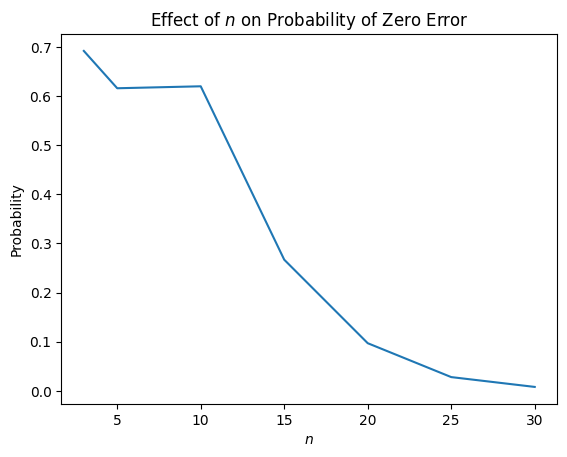

In [117]:
plt.plot(num_images_arr, num_correct_arr/float(num_trials))
plt.xlabel("$n$")
plt.ylabel("Probability")
plt.title("Effect of $n$ on Probability of Zero Error")